In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import helpers
import utils
import torch
from model_UNet import Model as UModel
from model_ENet import Model as EModel
import torchvision.transforms as transforms
from torchvision.datasets import Cityscapes
from torch.utils.data import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torchmetrics import Dice
from ptflops import get_model_complexity_info
from torch.nn.utils import prune

/Users/ilerisoy/anaconda3/envs/dev/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


## The Dataset
### Load the dataset

In [2]:
# Data path
data_path = "data"

# Define the transform for original data
resize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), antialias=False),  # Resize to 256x256
])

# Define the transform for data augmentation
rotation = helpers.RandomTransform(size=(256, 256), p=0.7, angle=20, jitter=False)

# Load the training data without any transformations
original_dataset = Cityscapes(data_path, split='train', mode='fine', target_type='semantic',
                        transform=resize_transform, target_transform=resize_transform)

# Load the training data with rotation transformations
rotated_dataset = Cityscapes(data_path, split='train', mode='fine', target_type='semantic', 
                            transforms=rotation)

# Load the test data
test_dataset = Cityscapes(data_path, split='val', mode='fine', target_type='semantic',
                          transform=resize_transform, target_transform=resize_transform)

# Concatenate the original and augmented datasets
train_dataset = ConcatDataset([original_dataset, rotated_dataset])

# Define the size of the validation set
val_size = int(0.02 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define the size of the validation set
val_size = int(0.02 * len(original_dataset))
original_size = len(original_dataset) - val_size

# Split the dataset
_, val_dataset = random_split(original_dataset, [original_size, val_size])

# Create DataLoaders for training, validation, test, and original sets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
original_dataloader = DataLoader(original_dataset, batch_size=4, shuffle=False)

print("Train loader size: ", len(train_loader))
print("Validation loader size: ", len(val_loader))
print("Test loader size: ", len(test_loader))
print("Original loader size: ", len(original_dataloader))

Train loader size:  2916
Validation loader size:  4
Test loader size:  125
Original loader size:  744


### Visualize the first batch

/Users/ilerisoy/anaconda3/envs/dev/lib/python3.8/site-packages/torchvision/transforms/functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256])
Type of images:  <class 'PIL.Image.Image'>
Batch size:  2


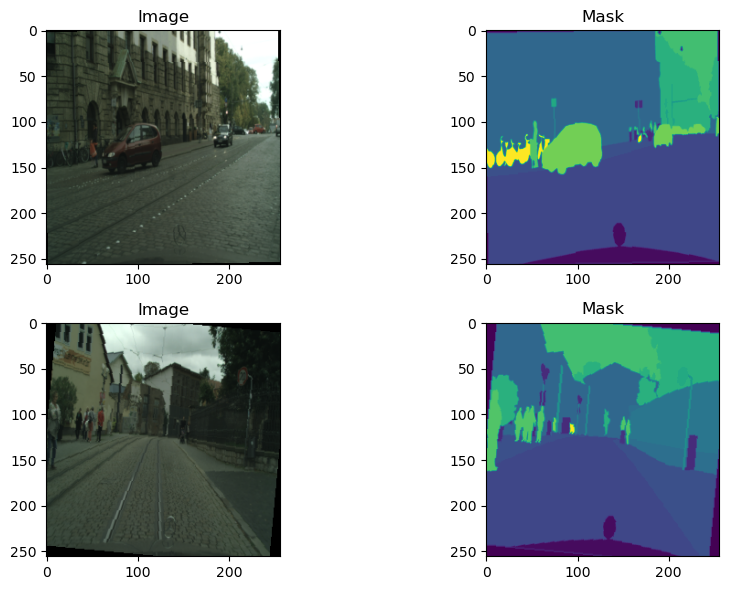

In [3]:
# Define the tensor to PIL image transform
to_pil = transforms.ToPILImage()

# Display the first batch of images and masks
for batch in train_loader:
    images, masks = batch 
    print(images.shape, masks.shape)

    pil_images = [to_pil(img) for img in images]
    pil_masks = [to_pil(mask) for mask in masks]
    
    print("Type of images: ",type(pil_images[0]))
    print("Batch size: ", len(pil_images))

    fig, axs = plt.subplots(nrows=len(pil_images), ncols=2, figsize=(10, 3*len(pil_images)))

    for i in range(len(pil_images)):
        axs[i, 0].imshow(pil_images[i])
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(pil_masks[i])
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

    break

## The Model

#### Define functions to visualize and analyze a pretrained model

In [4]:
# Color mapping for Cityscapes dataset
colors = {
    0: (0, 0, 0),
    1: (31, 119, 180),
    2: (255, 127, 14),  
    3: (44, 160, 44),   
    4: (214, 39, 40), 
    5: (148, 103, 189),
    6: (140, 86, 75),
    7: (227, 119, 194),
    8: (127, 127, 127),
    9: (188, 189, 34),
    10: (23, 190, 207),
    11: (174, 199, 232),
    12: (255, 187, 120),
    13: (152, 223, 138),
    14: (255, 152, 150),
    15: (197, 176, 213),
    16: (196, 156, 148),
    17: (247, 182, 210),
    18: (199, 199, 199),
    19: (219, 219, 141),
    20: (250, 250, 250),
    21: (255, 105, 180),
    22: (139, 0, 139),
    23: (0, 255, 255),
    24: (0, 255, 0),
    25: (255, 255, 0),
    26: (255, 165, 0),
    27: (255, 0, 0),
    28: (0, 0, 255),
    29: (0, 0, 128),
    30: (0, 128, 0),
    31: (128, 0, 0),
    32: (128, 128, 128),
    33: (0, 0, 0),
    34: (128, 128, 0),
    35: (128, 0, 128),
    255: (0, 0, 0)
}

# Class names for Cityscapes dataset
class_names = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 
               'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 
               'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 
               'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'license plate',
               'extra-1', 'extra-2', 'extra-3', 'extra-4', 'extra-5', 'extra-6', 'extra-7', 'extra-8', 'extra-9',]

def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            
            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            masks = utils.map_id_to_train_id(masks*255)

            images = images.numpy()
            masks = masks.numpy()

            predicted = predicted.numpy()

            for j in range(images.shape[0]):
                image = renormalize_image(images[j].transpose(1, 2, 0))

                mask = masks[j].squeeze()
                pred_mask = predicted[j]
                                
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                
                # Map class indices to class names from the VOC2012 dataset
                #classes_gt = [class_names[int(idx)] for idx in unique_classes_gt]
                #classes_pred = [class_names[int(idx)] for idx in unique_classes_pred]
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
                #plt.title(f'Ground Truth Mask Classes:\n {classes_gt}')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
                #plt.title(f'Predicted Mask Predicted Classes:\n {classes_pred}')
                plt.axis('off')

                plt.show()
                
def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]  
    renormalized_image = image * std + mean
    return renormalized_image

def get_total_parameters_count(model):
    """
    Calculate the total number of parameters in a model.

    Args:
        model (torch.nn.Module): The model to calculate parameters for.

    Returns:
        int: The total number of parameters in the model.
    """
    params = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {params}")
    return params

def get_pruned_parameters_count(pruned_model):
    """
    Calculate the total number of non-zero parameters in a pruned model.

    Args:
        pruned_model (torch.nn.Module): The pruned model to calculate parameters for.

    Returns:
        int: The total number of non-zero parameters in the pruned model.
    """
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    print(f"Number of non-zero parameters: {params}")
    return params

def calculate_model_reduction_percentage(original_model, pruned_model):
    """
    Calculate the model reduction percentage after pruning.

    Args:
        original_model (torch.nn.Module): The original model before pruning.
        pruned_model (torch.nn.Module): The pruned model after pruning.

    Returns:
        float: The model reduction percentage.
    """
    original_params = get_total_parameters_count(original_model)
    pruned_params = get_pruned_parameters_count(pruned_model)
    
    reduction_percentage = (original_params - pruned_params) / original_params * 100
    print(f"Model reduction percentage: {reduction_percentage:.2f}%")
    return reduction_percentage

def print_model_state_dict(model):
    """
    Print the state dictionary of a PyTorch model.

    Args:
        model (torch.nn.Module): The model to print the state dictionary for.

    Returns:
        None
    """
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

def calculate_average_dice_score(model, val_loader):
    print(f"Number of Batches: {len(val_loader)}")
    dice = Dice(average='macro', num_classes=19)
    model.eval()
    with torch.no_grad():
        total_dice_score = 0.0
        num_batches = 0
        for images, masks in val_loader:
            start_time = time.time()

            images, masks = images.to("cpu"), masks.to("cpu")
            outputs = model(images)

            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            masks = (masks * 255).long().squeeze()
            masks = utils.map_id_to_train_id(masks)

            # Create a mask where ground truth labels are not equal to 255
            valid_pixels = masks != 255

            # Apply the mask to the predicted and ground truth tensors
            valid_predicted = predicted[valid_pixels]
            valid_masks = masks[valid_pixels]

            dice_score = dice(valid_predicted, valid_masks)
            total_dice_score += dice_score
            num_batches += 1

            end_time = time.time()
            if num_batches == 1:
                print(f"Time taken for the first batch {num_batches}: {end_time - start_time:.4f} seconds")
                print(f"Dice Score: {dice_score:.4f}")
            
        # print(f"Average Dice Score: {total_dice_score / num_batches:.4f}")
            
        return total_dice_score / num_batches

#### Load the pre-trained model and visualize segmentation results

length of test_loader: 125


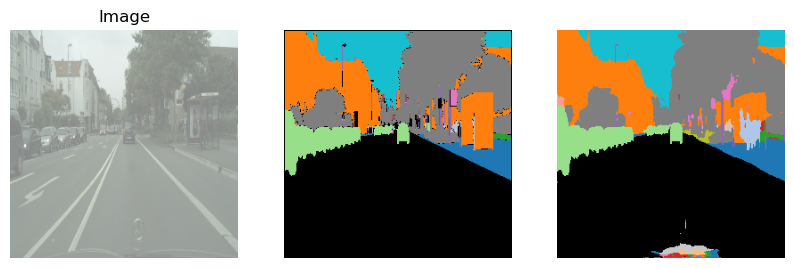

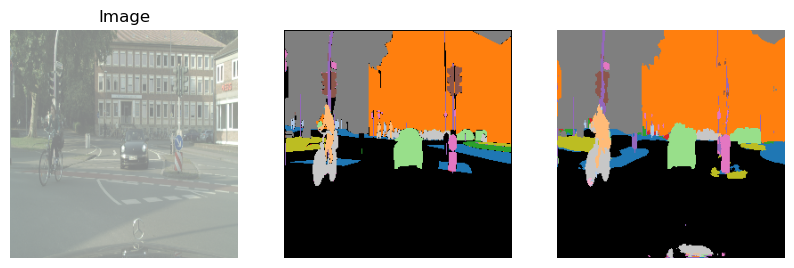

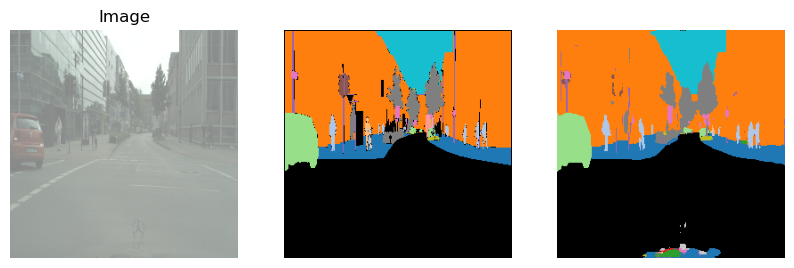

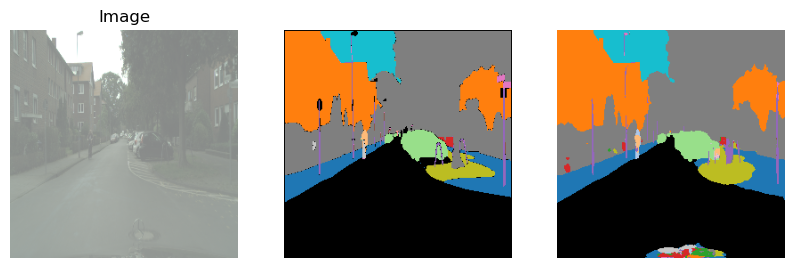

In [5]:
model_path = "ignore/models/UNet-model.pth"
base_model = UModel()
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
print(f"length of test_loader: {len(test_loader)}")

# Visualize segmentation results
visualize_segmentation(base_model, test_loader, num_examples=1)

#### Analyze the base model

In [6]:
input_tensor = torch.randn(1, 3, 224, 224)
flops, params = get_model_complexity_info(base_model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
print('Base Model:')
print('FLOPs:', flops)
print('Parameters:', params)

Base Model:
FLOPs: 42.06 GMac
Parameters: 31.05 M


In [18]:
backend = "qnnpack"
base_model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
quantized_model = torch.quantization.prepare(base_model,inplace=False)
for inputs, labels in test_loader:
    quantized_model(inputs)
quantized_model = torch.quantization.convert(quantized_model, inplace=False)

In [19]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

print_model_size(base_model)
print_model_size(quantized_model)

124.26 MB
31.21 MB


In [20]:
def prune_model(model, pruning_percentage):
    # Collect all the parameters to prune
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune.append((module, 'weight'))

    # Apply the pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_percentage,
    )

    # Remove the pruned weights
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

# Prune the model
pruned_model = base_model
prune_model(base_model, pruning_percentage=0.40)

In [21]:
# Calculate the model reduction percentage
reduction_percentage = calculate_model_reduction_percentage(base_model, pruned_model)

# Fails to save in sparse format
print_model_size(base_model)
print_model_size(pruned_model)

Total number of parameters: 31045666
Number of non-zero parameters: 19748975
Model reduction percentage: 36.39%
124.26 MB
124.26 MB


In [12]:
def calculate_inference_time(model, input_data):
    """
    Calculate the inference time for a single batch.

    Args:
        model (torch.nn.Module): The model to calculate inference time for.
        input_data (torch.Tensor): The input data for the model.

    Returns:
        float: The inference time in seconds.
    """
    start_time = time.time()
    with torch.no_grad():
        _ = model(input_data)
    end_time = time.time()

    inference_time = end_time - start_time
    return inference_time

In [17]:
# Assume input_data is the input for the models
input_data = torch.randn(1, 3, 224, 224)

base_time = calculate_inference_time(base_model, input_data)
print(f"Base model inference time: {base_time:.4f} seconds")

pruned_time = calculate_inference_time(pruned_model, input_data)
print(f"Model2prune inference time: {pruned_time:.4f} seconds")

quantized_time = calculate_inference_time(quantized_model, input_data)
print(f"Quantized model inference time: {quantized_time:.4f} seconds")

Base model inference time: 0.3217 seconds
Pruned Model inference time: 0.3097 seconds
Quantized model inference time: 0.2672 seconds
